Lab 5
var 5
Model training and testing.

Библиотеки

In [1]:
import torch
import os
import pandas as pd
import cv2
import glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from PIL import Image 
import torch.nn as nn
from torch.utils.data import *
import torch.optim as optim
import torch.nn.functional as F
import random

In [2]:
'''
Определяет, будет ли использоваться устройство "cuda" (если доступно) или "cpu" 
Устанавливает seed для генерации случайных чисел и выводит выбранное устройство.
'''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
print(device)

cpu


Разделение набора данных на выборки

In [3]:
'''
Создает кастомный датасет для обработки изображений. Класс `CustomDataset` наследует от `torch.utils.data.Dataset` и определяет методы `__init__`, `__len__` и `__getitem__`.
Он загружает изображения из файлового списка, применяет преобразования (если они указаны) и возвращает преобразованные изображения с соответствующими метками.

Создаются экземпляры кастомного датасета для обучающего, тестового и валидационного наборов данных, используя соответствующие списки файлов и преобразования.

Выводит информацию о втором элементе из обучающего датасета и метке первого элемента из валидационного датасета.
'''
val_path = os.path.abspath('val_list')
test_path = os.path.abspath('test_list')
train_path = os.path.abspath('train_list')

df = pd.read_csv('annotations_3.csv', sep=',', header=None)
df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'Absolute_path', 2: 'Class'}, inplace=True)
df.reset_index(inplace=True)
print(df)

for path in [val_path, test_path, train_path]:
    if not os.path.isdir(path):
        os.mkdir(path)

def load_image(df, path, i):
    image_path = os.path.abspath(os.path.join(*df.Absolute_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

for i in range(900, 1000):
    load_image(df, val_path, i)
for i in range(1900, 1999):
    load_image(df, val_path, i)
for i in range(800, 900):
    load_image(df, test_path, i)
for i in range(1800, 1900):
    load_image(df, test_path, i)
for i in range(800):
    load_image(df, train_path, i)
for i in range(1000, 1800):
    load_image(df, train_path, i)

train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index            Absolute_path       Class
0         1   dataset_random/172.jpg  brown bear
1         2  dataset_random/8127.jpg  brown bear
2         3  dataset_random/8475.jpg  brown bear
3         4  dataset_random/5164.jpg  brown bear
4         5  dataset_random/2872.jpg  brown bear
...     ...                      ...         ...
1995   1996  dataset_random/9294.jpg  polar bear
1996   1997  dataset_random/9313.jpg  polar bear
1997   1998  dataset_random/9478.jpg  polar bear
1998   1999  dataset_random/2315.jpg  polar bear
1999   2000  dataset_random/7044.jpg  polar bear

[2000 rows x 3 columns]


Проверка

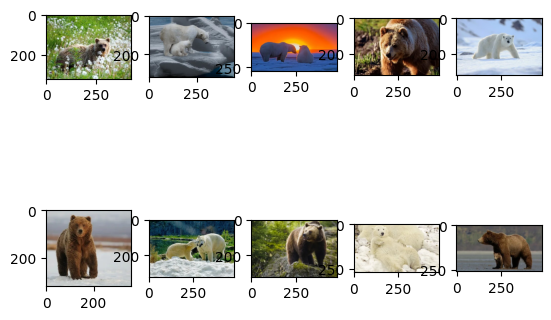

In [4]:
'''
Генерирует 10 случайных индексов из диапазона от 0 до 199 без повторений
Отображает изображения из обучающего списка с использованием библиотеки matplotlib.
'''
random_idx = np.random.choice(200, size=10, replace=False)

fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    img = cv2.imread(train_list[random_idx[i]])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

Увелечение изображений

In [5]:
'''
Определяет наборы преобразований для обучающего, валидационного и тестового наборов данных
таких как изменение размера, случайное обрезание, горизонтальное отражение и преобразование в тензоры.
'''
common_transforms = [
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ]

train_transforms = transforms.Compose(common_transforms)
val_transforms = transforms.Compose(common_transforms)
test_transforms = transforms.Compose(common_transforms)

Загрузка 

In [6]:
'''
Определяет пути к директориям для валидационного, тестового и обучающего наборов данных.
Считывает и предобрабатывает CSV-файл с аннотациями, затем создает директории, если они не существуют.
Определяет функцию для загрузки и сохранения изображений.
Обрабатывает изображения на основе заданных диапазонов.
Создает списки файлов изображений и разделяет обучающий список на обучающий и валидационный наборы данных.
'''
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        if self.transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = img

        label = 1 if 'polar bear' in img_path else 0 
        return img_transformed, label

In [7]:
'''
Создание кастомного датасета для обучения, тестирования и валидации модели
C использованием предварительно определенных преобразований.
'''
train_data = CustomDataset(train_list, transform=train_transforms)
test_data = CustomDataset(test_list, transform=test_transforms)
val_data = CustomDataset(val_list, transform=val_transforms)

Проверка

In [8]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.5373, 0.5373, 0.5373,  ..., 0.4784, 0.4824, 0.4824],
         [0.5373, 0.5373, 0.5373,  ..., 0.4784, 0.4824, 0.4824],
         [0.5373, 0.5373, 0.5373,  ..., 0.4824, 0.4863, 0.4863],
         ...,
         [0.6353, 0.6353, 0.6353,  ..., 0.8235, 0.8196, 0.8196],
         [0.6392, 0.6392, 0.6392,  ..., 0.8118, 0.8078, 0.8078],
         [0.6392, 0.6392, 0.6392,  ..., 0.8118, 0.8078, 0.8078]],

        [[0.5647, 0.5647, 0.5647,  ..., 0.5098, 0.5137, 0.5137],
         [0.5647, 0.5647, 0.5647,  ..., 0.5098, 0.5137, 0.5137],
         [0.5647, 0.5647, 0.5647,  ..., 0.5137, 0.5176, 0.5176],
         ...,
         [0.6275, 0.6275, 0.6275,  ..., 0.7686, 0.7647, 0.7647],
         [0.6314, 0.6314, 0.6314,  ..., 0.7529, 0.7490, 0.7490],
         [0.6314, 0.6314, 0.6314,  ..., 0.7529, 0.7490, 0.7490]],

        [[0.6039, 0.6039, 0.6039,  ..., 0.5922, 0.5922, 0.5922],
         [0.6039, 0.6039, 0.6039,  ..., 0.5922, 0.5922, 0.5922],
         [0.6039, 0.6039, 0.6039,  ..., 0.5922, 0.5922, 0

Обучение

In [9]:
lr = 0.001
batch_size = 10
epochs = 10

In [10]:
def create_loaders():
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
    return (train_loader, test_loader, val_loader)

train_loader, test_loader, val_loader = create_loaders()

In [11]:
print(len(train_data), len(train_loader))

2880 288


In [12]:
print(len(val_data), len(val_loader))

320 32


Построение модели

In [13]:
class Conv(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )


        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
model = Conv().to(device)
model.train()

Conv(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=10, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [15]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

2880 288
320 32


torch.Size([3, 224, 224])

task 5-6

Epoch : 1, train acc : 0.7479169368743896, train loss : 0.5083803534507751
Epoch : 1, val_acc : 0.7406249046325684, val_loss : 0.4767840802669525
Epoch : 2, train acc : 0.7510419487953186, train loss : 0.47839224338531494
Epoch : 2, val_acc : 0.7406249046325684, val_loss : 0.4561041593551636
Epoch : 3, train acc : 0.7513892650604248, train loss : 0.47318950295448303
Epoch : 3, val_acc : 0.737500011920929, val_loss : 0.4753125309944153
Epoch : 4, train acc : 0.7506948709487915, train loss : 0.473095566034317
Epoch : 4, val_acc : 0.7406249046325684, val_loss : 0.4670186936855316
Epoch : 5, train acc : 0.7510418891906738, train loss : 0.47770118713378906
Epoch : 5, val_acc : 0.7406249046325684, val_loss : 0.48034411668777466
Epoch : 6, train acc : 0.7510418891906738, train loss : 0.47206050157546997
Epoch : 6, val_acc : 0.7406249046325684, val_loss : 0.46678248047828674
Epoch : 7, train acc : 0.7510421276092529, train loss : 0.4648432433605194
Epoch : 7, val_acc : 0.7406249046325684, val_

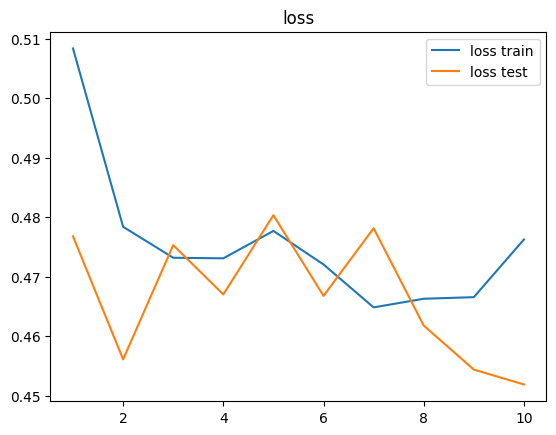

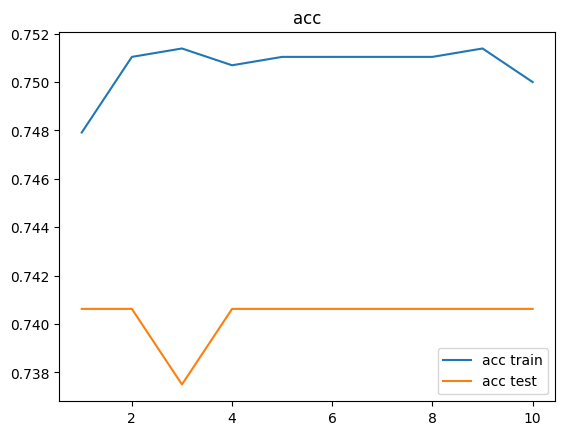

In [16]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

def train(model, epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  epoch_val_acc_list = []
  epoch_val_loss_list = []
  epoch_acc_list = []
  epoch_loss_list = []

  for epoch in range(epochs):
      epoch_loss = 0
      epoch_acc = 0

      for data, label in train_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_acc += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)

      print('Epoch : {}, train acc : {}, train loss : {}'.format(epoch+1, epoch_acc,epoch_loss))
      epoch_acc_list.append(epoch_acc)
      epoch_loss_list.append(epoch_loss)
      with torch.no_grad():
          epoch_val_acc=0
          epoch_val_loss =0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)
              val_output = model(data)
              val_loss = criterion(val_output,label)

              acc = ((val_output.argmax(dim=1) == label).float().mean())
              epoch_val_acc += acc/ len(val_loader)
              epoch_val_loss += val_loss/ len(val_loader)

          print('Epoch : {}, val_acc : {}, val_loss : {}'.format(epoch+1, epoch_val_acc,epoch_val_loss))

      epoch_val_acc_list.append(epoch_val_acc)
      epoch_val_loss_list.append(epoch_val_loss)

  return(epoch_val_acc_list,epoch_val_loss_list,
  epoch_acc_list,
  epoch_loss_list)

epoch_val_acc_list, epoch_val_loss_list, epoch_acc_list, epoch_loss_list = train(model, epochs)

def show_plot(lis, list_val, text):
  x = list(range(1, len(lis)+ 1))
  plt.plot(x, lis, label = text+" train")
  plt.plot(x, list_val, label = text+" test")
  plt.title(text)
  plt.legend()
  plt.show()

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "loss")
show_plot(epoch_acc_list, epoch_val_acc_list, "acc")

Epoch : 1, train acc : 0.7510421276092529, train loss : 0.4546710252761841
Epoch : 1, val_acc : 0.7406249642372131, val_loss : 0.4463944435119629
Epoch : 2, train acc : 0.7506950497627258, train loss : 0.45885294675827026
Epoch : 2, val_acc : 0.721875011920929, val_loss : 0.44843438267707825
Epoch : 3, train acc : 0.7531251311302185, train loss : 0.45878398418426514
Epoch : 3, val_acc : 0.7406249642372131, val_loss : 0.47554999589920044
Epoch : 4, train acc : 0.748263955116272, train loss : 0.4588969349861145
Epoch : 4, val_acc : 0.7343749403953552, val_loss : 0.4516822099685669
Epoch : 5, train acc : 0.7506948113441467, train loss : 0.45165571570396423
Epoch : 5, val_acc : 0.7406251430511475, val_loss : 0.433094322681427
Epoch : 6, train acc : 0.7500003576278687, train loss : 0.4551292061805725
Epoch : 6, val_acc : 0.7406249642372131, val_loss : 0.4592974781990051
Epoch : 7, train acc : 0.7486117482185364, train loss : 0.4559555649757385
Epoch : 7, val_acc : 0.7312499284744263, val_lo

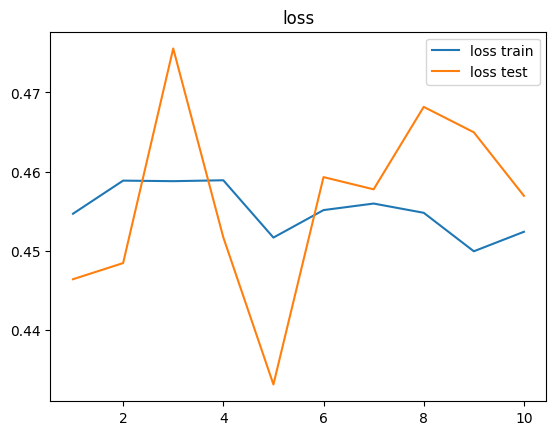

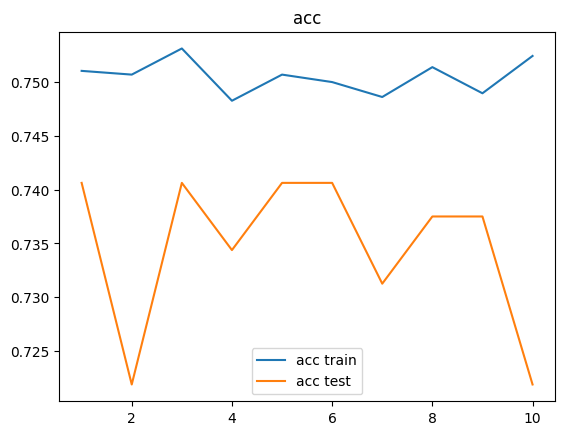

In [17]:
lr = 0.0005 # lr
batch_size = 10 # we will use mini-batch method

train_loader, test_loader, val_loader = create_loaders()

epoch_val_acc_list, epoch_val_loss_list, epoch_acc_list, epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "loss")
show_plot(epoch_acc_list, epoch_val_acc_list, "acc")

Epoch : 1, train acc : 0.6774312257766724, train loss : 0.5144079327583313
Epoch : 1, val_acc : 0.6468749642372131, val_loss : 0.4742704927921295
Epoch : 2, train acc : 0.7163197994232178, train loss : 0.487335741519928
Epoch : 2, val_acc : 0.7406249642372131, val_loss : 0.48082175850868225
Epoch : 3, train acc : 0.7510422468185425, train loss : 0.4786911606788635
Epoch : 3, val_acc : 0.7406249642372131, val_loss : 0.45968520641326904
Epoch : 4, train acc : 0.7510418891906738, train loss : 0.4654961824417114
Epoch : 4, val_acc : 0.7406250238418579, val_loss : 0.4409731924533844
Epoch : 5, train acc : 0.7510420083999634, train loss : 0.4642672538757324
Epoch : 5, val_acc : 0.7406249046325684, val_loss : 0.45943397283554077
Epoch : 6, train acc : 0.7510418891906738, train loss : 0.4532906115055084
Epoch : 6, val_acc : 0.7406250238418579, val_loss : 0.46057647466659546
Epoch : 7, train acc : 0.7510418891906738, train loss : 0.45772215723991394
Epoch : 7, val_acc : 0.7406249046325684, val_

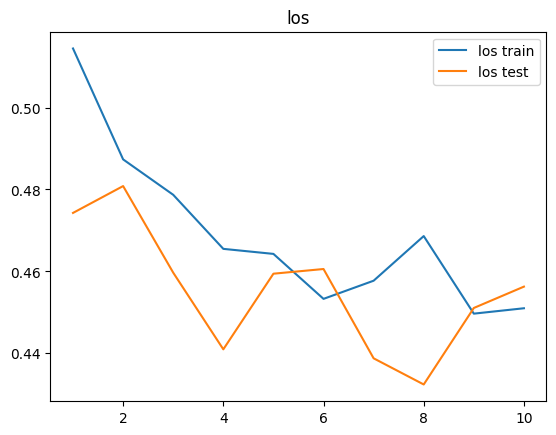

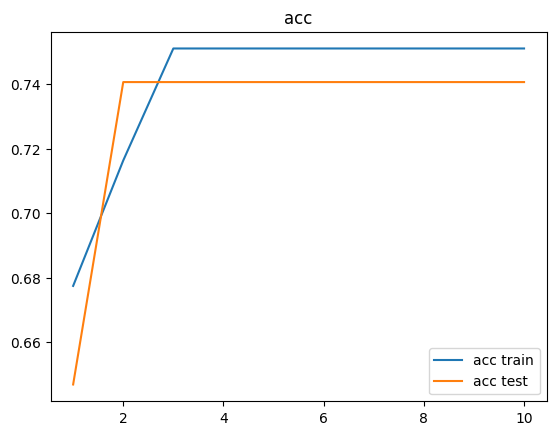

In [18]:
lr = 0.0007 # learning_rate
batch_size = 10 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train acc : 0.739583432674408, train loss : 0.5698853135108948
Epoch : 1, val_acc : 0.7562500238418579, val_loss : 0.537907600402832
Epoch : 2, train acc : 0.7506940960884094, train loss : 0.5413243174552917
Epoch : 2, val_acc : 0.7406250834465027, val_loss : 0.5402117371559143
Epoch : 3, train acc : 0.7510415315628052, train loss : 0.5196729898452759
Epoch : 3, val_acc : 0.7406249642372131, val_loss : 0.5141984224319458
Epoch : 4, train acc : 0.751041829586029, train loss : 0.5165313482284546
Epoch : 4, val_acc : 0.7406250238418579, val_loss : 0.4988535940647125
Epoch : 5, train acc : 0.7510416507720947, train loss : 0.5083587169647217
Epoch : 5, val_acc : 0.7406249642372131, val_loss : 0.522315502166748
Epoch : 6, train acc : 0.751041829586029, train loss : 0.5091601610183716
Epoch : 6, val_acc : 0.7406250238418579, val_loss : 0.5158802270889282
Epoch : 7, train acc : 0.7510417699813843, train loss : 0.5102044343948364
Epoch : 7, val_acc : 0.7406249642372131, val_loss : 0.

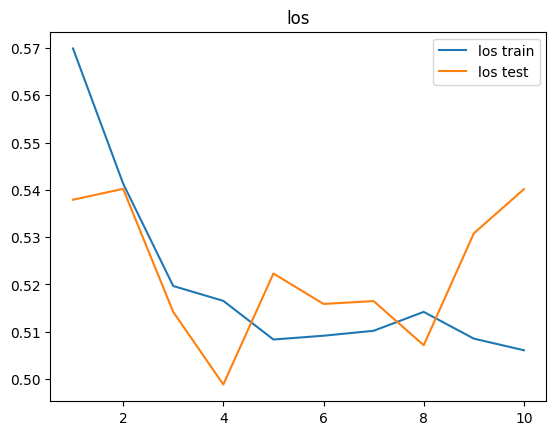

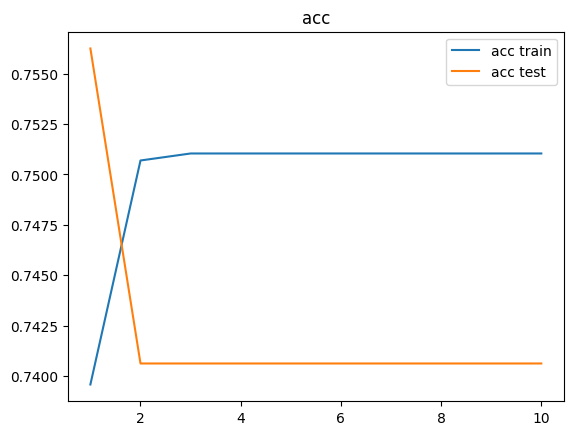

In [19]:
lr = 0.001 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train acc : 0.7440973520278931, train loss : 0.47756433486938477
Epoch : 1, val_acc : 0.7406250238418579, val_loss : 0.4604603350162506
Epoch : 2, train acc : 0.7510417103767395, train loss : 0.44991883635520935
Epoch : 2, val_acc : 0.7406249642372131, val_loss : 0.4437156021595001
Epoch : 3, train acc : 0.7510416507720947, train loss : 0.4449019432067871
Epoch : 3, val_acc : 0.7406250238418579, val_loss : 0.44053590297698975
Epoch : 4, train acc : 0.7510417699813843, train loss : 0.45826205611228943
Epoch : 4, val_acc : 0.7406250834465027, val_loss : 0.43430909514427185
Epoch : 5, train acc : 0.7510417699813843, train loss : 0.4435141980648041
Epoch : 5, val_acc : 0.7406249642372131, val_loss : 0.4218369126319885
Epoch : 6, train acc : 0.7510417103767395, train loss : 0.44032105803489685
Epoch : 6, val_acc : 0.7406249642372131, val_loss : 0.43126335740089417
Epoch : 7, train acc : 0.7510417699813843, train loss : 0.4335298538208008
Epoch : 7, val_acc : 0.7406249642372131, v

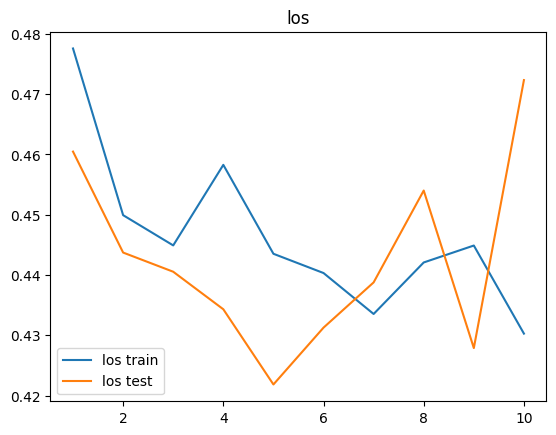

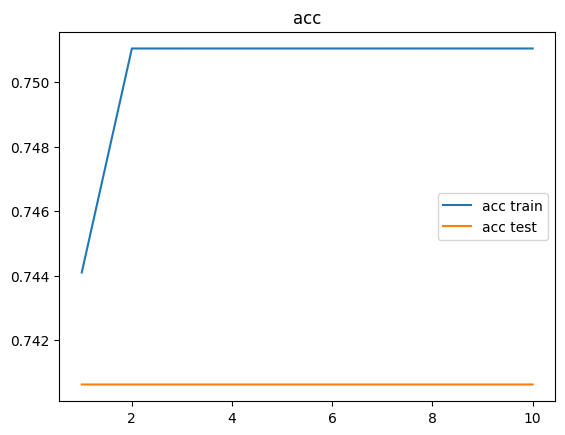

In [20]:
lr = 0.0005 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train acc : 0.7472221255302429, train loss : 0.5166178941726685
Epoch : 1, val_acc : 0.7406250238418579, val_loss : 0.5027761459350586
Epoch : 2, train acc : 0.7510414123535156, train loss : 0.48061925172805786
Epoch : 2, val_acc : 0.7406250238418579, val_loss : 0.4710331857204437
Epoch : 3, train acc : 0.75104159116745, train loss : 0.47686129808425903
Epoch : 3, val_acc : 0.7406249046325684, val_loss : 0.4563545882701874
Epoch : 4, train acc : 0.7510416507720947, train loss : 0.4614311754703522
Epoch : 4, val_acc : 0.7406249642372131, val_loss : 0.4693787395954132
Epoch : 5, train acc : 0.7510417103767395, train loss : 0.460265576839447
Epoch : 5, val_acc : 0.7406250238418579, val_loss : 0.4834960699081421
Epoch : 6, train acc : 0.7510418891906738, train loss : 0.4648524522781372
Epoch : 6, val_acc : 0.7406250834465027, val_loss : 0.44349420070648193
Epoch : 7, train acc : 0.75104159116745, train loss : 0.4673263132572174
Epoch : 7, val_acc : 0.7406250834465027, val_loss :

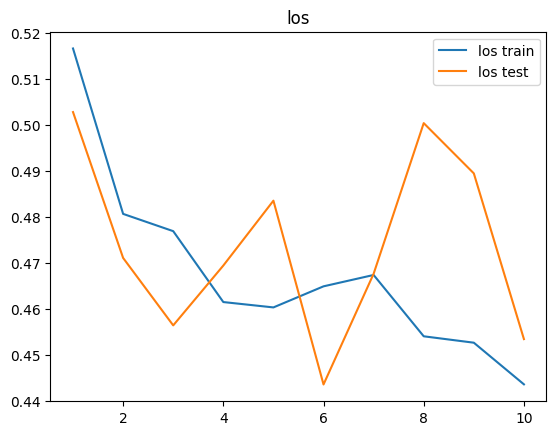

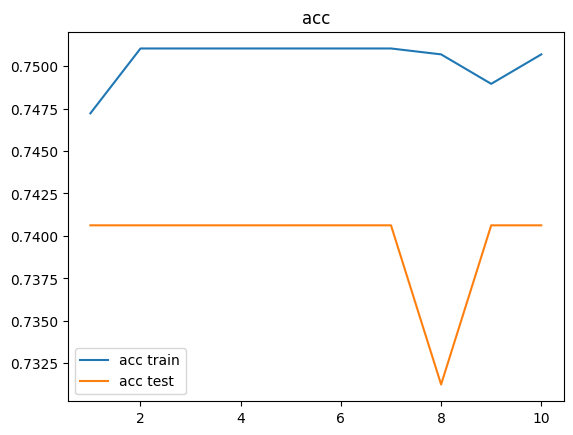

In [21]:
lr = 0.0007 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train acc : 0.7394253611564636, train loss : 0.4727676808834076
Epoch : 1, val_acc : 0.7542858123779297, val_loss : 0.436710923910141
Epoch : 2, train acc : 0.750689685344696, train loss : 0.4470464587211609
Epoch : 2, val_acc : 0.75, val_loss : 0.4470202326774597
Epoch : 3, train acc : 0.751609206199646, train loss : 0.4428304433822632
Epoch : 3, val_acc : 0.7242857217788696, val_loss : 0.4699286222457886
Epoch : 4, train acc : 0.7516091465950012, train loss : 0.43626004457473755
Epoch : 4, val_acc : 0.7499999403953552, val_loss : 0.42375698685646057
Epoch : 5, train acc : 0.7502297759056091, train loss : 0.4509640038013458
Epoch : 5, val_acc : 0.7457143068313599, val_loss : 0.42207738757133484
Epoch : 6, train acc : 0.750689685344696, train loss : 0.43461260199546814
Epoch : 6, val_acc : 0.7242857217788696, val_loss : 0.42428427934646606
Epoch : 7, train acc : 0.751609206199646, train loss : 0.42969924211502075
Epoch : 7, val_acc : 0.7499999403953552, val_loss : 0.44894948

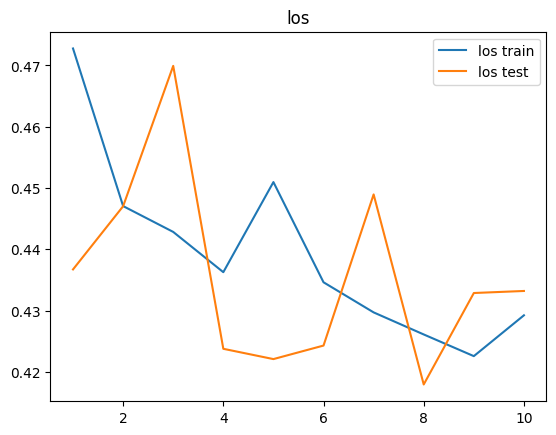

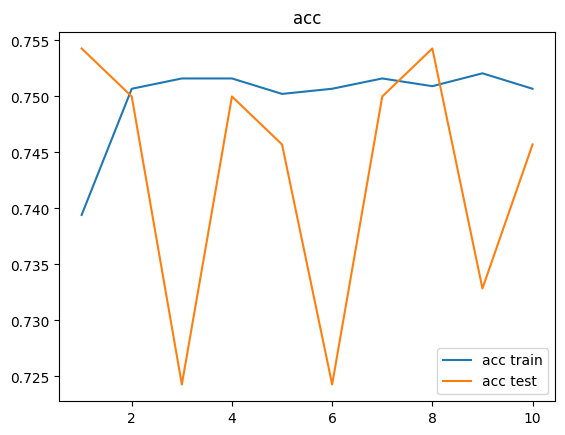

In [22]:
lr = 0.001 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train acc : 0.7486204504966736, train loss : 0.46866726875305176
Epoch : 1, val_acc : 0.741428554058075, val_loss : 0.4531112313270569
Epoch : 2, train acc : 0.7516093254089355, train loss : 0.4576858580112457
Epoch : 2, val_acc : 0.7414286136627197, val_loss : 0.44083917140960693
Epoch : 3, train acc : 0.7506896257400513, train loss : 0.4500405788421631
Epoch : 3, val_acc : 0.741428554058075, val_loss : 0.4216480851173401
Epoch : 4, train acc : 0.75091952085495, train loss : 0.4466712474822998
Epoch : 4, val_acc : 0.741428554058075, val_loss : 0.4233739376068115
Epoch : 5, train acc : 0.7504598498344421, train loss : 0.4477972984313965
Epoch : 5, val_acc : 0.7285714149475098, val_loss : 0.44917601346969604
Epoch : 6, train acc : 0.7509195804595947, train loss : 0.43434861302375793
Epoch : 6, val_acc : 0.7328571081161499, val_loss : 0.45075803995132446
Epoch : 7, train acc : 0.7509195804595947, train loss : 0.4343900978565216
Epoch : 7, val_acc : 0.7371428608894348, val_loss

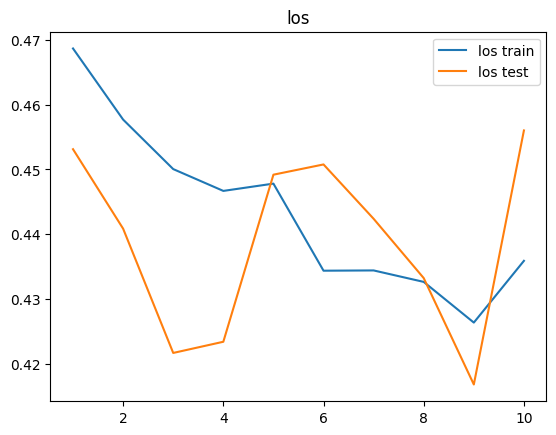

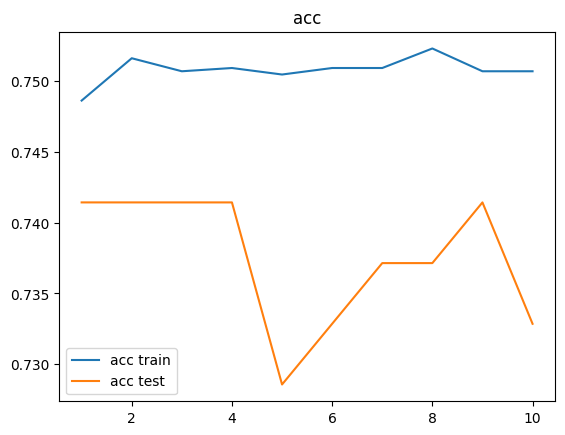

In [24]:
lr = 0.0005 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train acc : 0.6525288224220276, train loss : 0.5544275045394897
Epoch : 1, val_acc : 0.7371429204940796, val_loss : 0.5113518238067627
Epoch : 2, train acc : 0.7503448128700256, train loss : 0.5118756890296936
Epoch : 2, val_acc : 0.7457142472267151, val_loss : 0.4663688838481903
Epoch : 3, train acc : 0.7518391609191895, train loss : 0.49991416931152344
Epoch : 3, val_acc : 0.741428554058075, val_loss : 0.5102517604827881
Epoch : 4, train acc : 0.7500001192092896, train loss : 0.49331262707710266
Epoch : 4, val_acc : 0.7328571081161499, val_loss : 0.5131718516349792
Epoch : 5, train acc : 0.7506895661354065, train loss : 0.4853842556476593
Epoch : 5, val_acc : 0.7457143068313599, val_loss : 0.47334975004196167
Epoch : 6, train acc : 0.7520689964294434, train loss : 0.4890226721763611
Epoch : 6, val_acc : 0.7414286136627197, val_loss : 0.48215579986572266
Epoch : 7, train acc : 0.7513793706893921, train loss : 0.4815220236778259
Epoch : 7, val_acc : 0.758571445941925, val_lo

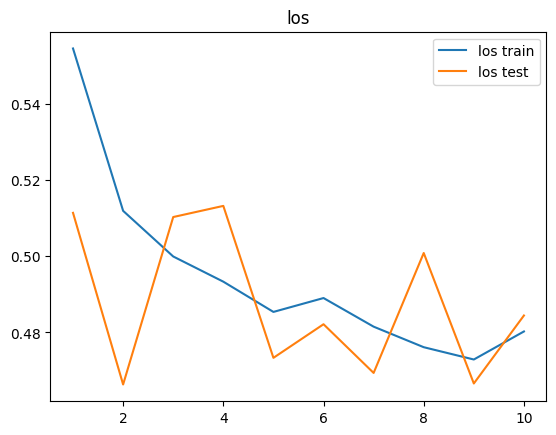

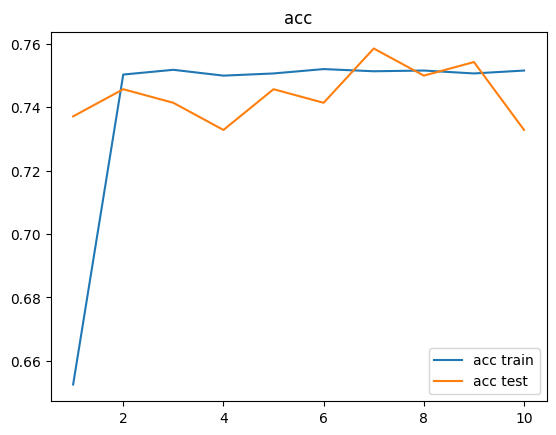

In [25]:
lr = 0.0007 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Conv().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Работа с моделью

In [26]:
brown_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        brown_probs += list(zip(labels, preds_list))

brown_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],brown_probs))
prob = list(map(lambda x: x[1],brown_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,tensor(0),0.406060
1,tensor(0),0.406060
2,tensor(0),0.406060
3,tensor(0),0.013563
4,tensor(0),0.012925
...,...,...
195,tensor(0),0.012504
196,tensor(0),0.406060
197,tensor(0),0.406060
198,tensor(0),0.009609


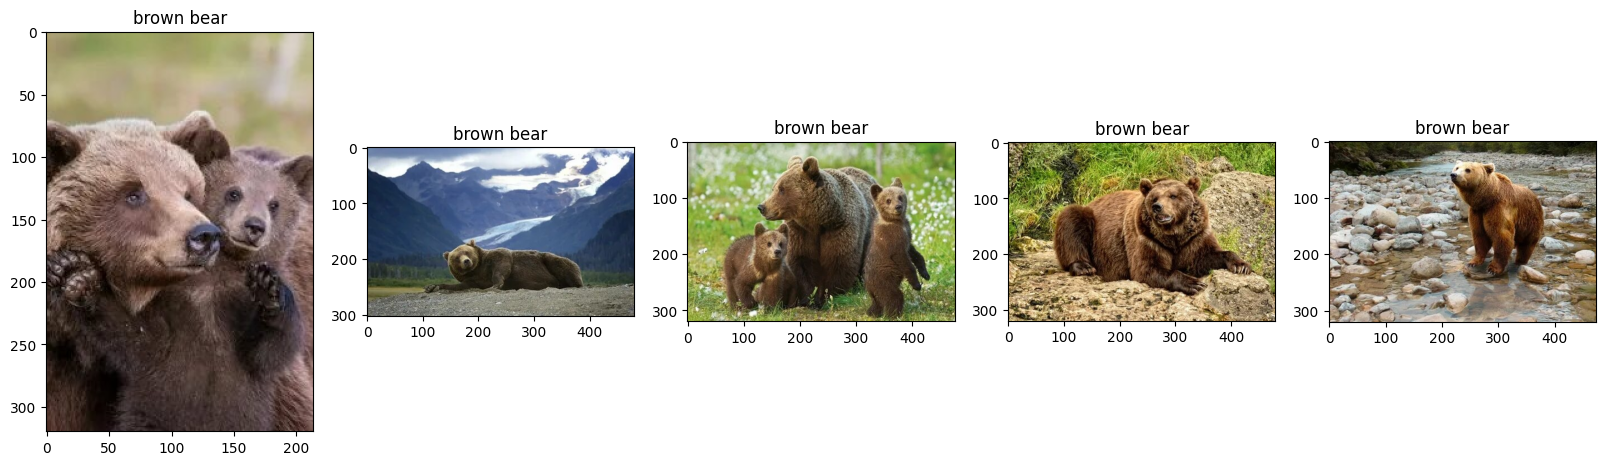

In [39]:
import random

class_ = {1: 'polar bear', 0: 'brown bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

indices_to_display = random.sample(submission.index.tolist(), 5)

for i, ax in zip(indices_to_display, axes):
    label = submission.loc[i, 'label']
    label = 1 if label > 0.5 else 0
    
    img_path = os.path.join(train_path, f'{i}.jpg')
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.set_title(class_[label])
        ax.imshow(img)
    else:
        ax.set_title('Image Not Found')


Сохранение модели и работа на тестовых данных

In [40]:
torch.save(model.state_dict(), os.path.join("/Users/amirbajmukasev/pp_5", "weight.pt"))

In [41]:
mymodel = Conv()
mymodel.load_state_dict(torch.load(os.path.join("/Users/amirbajmukasev/pp_5", "weight.pt")))

<All keys matched successfully>

'polar bear'

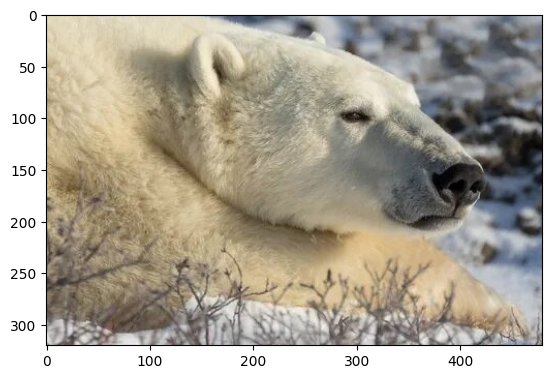

In [42]:
list_files = os.listdir(val_path)
file = list_files[random.randint(0,len(list_files)-1)]


img_path = os.path.join(val_path, file)

img = Image.open(img_path)
img_transformed = test_transforms(img).unsqueeze(dim=0)

output = mymodel(img_transformed)

img = Image.open(img_path)
plt.imshow(img)

preds_list = "polar bear" if output.argmax(dim=1) == 0 else "brown bear"

preds_list

In [45]:
l = []

train_loader, test_loader, val_loader = create_loaders()

for data, label in val_loader:
    output = mymodel(data)
    l.append(output.argmax(dim=1) == label)

l

[tensor([ True, False,  True,  True, False,  True,  True,  True, False,  True,
          True, False,  True,  True, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False,  True,  True, False,  True,
         False, False,  True, False,  True,  True,  True,  True,  True,  True]),
 tensor([ True,  True,  True, False,  True, False,  True,  True,  True,  True,
          True, False,  True,  True,  True, False,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False,  True, False, False,  True, False,  True,  True,  True,  True]),
 tensor([ True,  True,  True, False,  True,  True, False,  True,  True, False,
          True,  True,  True,  True, False, False,  True,  True, False,  True,
          True,  True,  True,  True,  True,  Tru

In [46]:
sum = 0
count = 0
for i in l:
    sum += torch.sum(i.float())
    count += len(i)

sum / count 

tensor(0.7406)